In [ ]:
%pip install scikeras

In [ ]:
import tensorflow
import numpy as np
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Data Collection


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
len(X):  98
len(y):  98


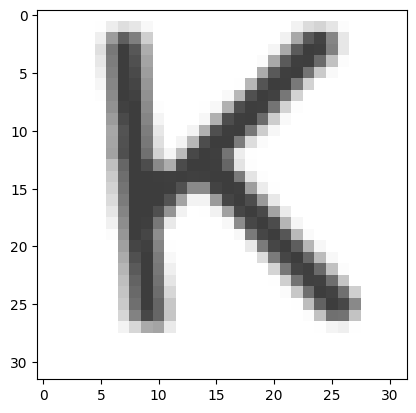

In [ ]:
import re
from google.colab import drive
import os
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/CS4243/'

X = []
y = []

for filename in os.listdir(folder_path):
    re_match = re.search(r'(\d+)(?=\.png)', filename)
    if not re_match:
        print(f"Could not read {filename}")

    digit = int(re_match.group(1))
    if digit != 0:
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            # Resize the image to 32x32 pixels
            resized_image = cv2.resize(image, (32, 32))
            X.append(resized_image)
            y.append(filename[digit - 1])
        else:
            print(f"Could not read {filename}")

plt.imshow(cv2.cvtColor(X[4], cv2.COLOR_BGR2RGB))
print('len(X): ', len(X))
print('len(y): ', len(y))

X = np.array(X)
y = np.array(y)

# Data Preprocessing


In [ ]:
digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
char_list = digits + letters

# Normalize


def normalize_data(data):
    return data / 255.0

# One hot encoding


def one_hot_encode_labels(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    encoded = label_encoder.transform(labels)
    categorical = to_categorical(encoded, num_classes=36)

    return categorical


def inverse_transform_labels(encoded_labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    return label_encoder.inverse_transform(encoded_labels)


X = normalize_data(X)
y = one_hot_encode_labels(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(
    (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# Model


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

# Build Model Function


def build_model(learning_rate=0.01, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
              activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(36, activation='softmax'))  # 0-9, a-z

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Train Model Function


def train_model(X, y):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    y_encoded = label_encoder.transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=36)

    model = build_model(input_shape=X.shape[1:])  # Using input shape from X
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X, y_categorical, epochs=10, batch_size=32)

    return model, label_encoder

# Predict Function


def predict_model(model, label_encoder, X):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    return predicted_labels

# Cross Validation


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_model()

    model.fit(X_train_fold, y_train_fold, epochs=10,
              validation_data=(X_val_fold, y_val_fold),
              batch_size=64)

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    kf_accuracy.append(val_acc)

print(f'Cross-Validation Accuracies: {kf_accuracy}')
print(f'Mean Accuracy: {np.mean(kf_accuracy)}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0323 - loss: 3.7355 - val_accuracy: 0.0000e+00 - val_loss: 3.6016
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5000 - loss: 2.3668 - val_accuracy: 0.0625 - val_loss: 3.5812
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8065 - loss: 1.5661 - val_accuracy: 0.0625 - val_loss: 3.5552
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8871 - loss: 1.0129 - val_accuracy: 0.0625 - val_loss: 3.5371
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8871 - loss: 0.6518 - val_accuracy: 0.0625 - val_loss: 3.5366
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9194 - loss: 0.4396 - val_accuracy: 0.0625 - val_loss: 3.5497
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9194 - loss: 0.3152 - val_accuracy: 0.0000e+00 - val_loss: 3.5810
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9194 - loss: 0.2380 - val_accuracy: 0.0000e+00 - val_loss: 3.6

# Hyperparameter Tuning


In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=build_model, verbose=0)

# Define the grid of hyperparameters
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.0, 0.2, 0.5],
}

# Conduct the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_result.best_params_}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters: {'model__dropout_rate': 0.5, 'model__learning_rate': 0.001}


In [ ]:
model = build_model(learning_rate=0.001, dropout_rate=0.5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
